# 残差网络（ResNet）
:label:`sec_resnet`

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力，
为了取得质的突破，我们需要一些数学基础知识。

## 函数类

首先，假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。
对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。
现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。
相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。
例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？
唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。
换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。
然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。
事实上，$f^*_{\mathcal{F}'}$可能更糟：
如 :numref:`fig_functionclasses`所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。
在 :numref:`fig_functionclasses`的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。
相反对于 :numref:`fig_functionclasses`右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（ $f^*$ ）。这种现象在嵌套函数类中不会发生。](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。
对于深度神经网络，如果我们能将新添加的层训练成*恒等映射*（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了*残差网络*（ResNet） :cite:`He.Zhang.Ren.ea.2016`。
它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
于是，*残差块*（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。
凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

## (**残差块**)

让我们聚焦于神经网络局部：如图 :numref:`fig_residual_block`所示，假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为 :numref:`fig_residual_block`上方激活函数的输入）。
 :numref:`fig_residual_block`左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。
残差映射在现实中往往更容易优化。
以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将 :numref:`fig_residual_block`中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。
实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。
 :numref:`fig_residual_block`右图是ResNet的基础架构--*残差块*（residual block）。
在残差块中，输入可通过跨层数据线路更快地向前传播。

![一个正常块（左图）和一个残差块（右图）。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/residual-block.svg?raw=1)
:label:`fig_residual_block`

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：


In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
class Residual(nn.Module):
  def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                           kernel_size=3, padding=1, stride=strides) # 3*3卷积
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                           kernel_size=3, padding=1) # 3*3卷积
    if use_1x1conv: # 需要变维度来匹配干路
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                             kernel_size=1, stride=strides)
    else: # 不需要变维度来匹配干路
      self.conv3= None

    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

如 :numref:`fig_resnet_block`所示，此代码生成两种类型的网络：
一种是当`use_1x1conv=False`时，应用ReLU非线性函数之前，将输入添加到输出。
另一种是当`use_1x1conv=True`时，添加通过$1 \times 1$卷积调整通道和分辨率。

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/resnet-block.svg?raw=1)
:label:`fig_resnet_block`

下面我们来查看[**输入和输出形状一致**]的情况。


In [ ]:
block = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = block(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [ ]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet模型**]

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。


In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。


In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block: # 除了第1块以外所有的块都需要经过1*1卷积核变维
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。


In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。


In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。
 :numref:`fig_resnet18`描述了完整的ResNet-18。

![ResNet-18 架构](http://d2l.ai/_images/resnet18.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。


In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

同之前一样，我们在Fashion-MNIST数据集上训练ResNet。


loss 0.014, train acc 0.996, test acc 0.922
1769.4 examples/sec on cuda:0


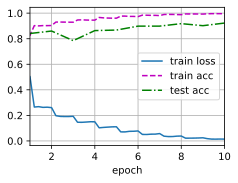

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
* 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

## 练习

1.  :numref:`fig_inception`中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
1. 参考ResNet论文 :cite:`He.Zhang.Ren.ea.2016`中的表1，以实现不同的变体。
1. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。
1. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 :cite:`He.Zhang.Ren.ea.2016*1`中的图1。
1. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？


### 对于第4题的尝试


In [ ]:
class Residual_bnFirst(nn.Module):
  def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                           kernel_size=3, padding=1, stride=strides) # 3*3卷积
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                           kernel_size=3, padding=1) # 3*3卷积
    if use_1x1conv: # 需要变维度来匹配干路
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                             kernel_size=1, stride=strides)
    else: # 不需要变维度来匹配干路
      self.conv3= None

    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.conv1(self.bn1(X)))
    Y = self.conv2(self.bn2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

loss 0.045, train acc 0.984, test acc 0.899
1658.6 examples/sec on cuda:0


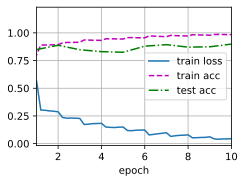

In [ ]:
class Residual_bnFirst(nn.Module):
  def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                           kernel_size=3, padding=1, stride=strides) # 3*3卷积
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                           kernel_size=3, padding=1) # 3*3卷积
    if use_1x1conv: # 需要变维度来匹配干路
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                             kernel_size=1, stride=strides)
    else: # 不需要变维度来匹配干路
      self.conv3= None

    self.bn1 = nn.BatchNorm2d(input_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = self.conv1(F.relu(self.bn1(X)))
    Y = self.conv2(F.relu(self.bn2(Y)))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)


def resnet_block_bnFirst(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block: # 除了第1块以外所有的块都需要经过1*1卷积核变维
            blk.append(Residual_bnFirst(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual_bnFirst(num_channels, num_channels))
    return blk

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block_bnFirst(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block_bnFirst(64, 128, 2))
b4 = nn.Sequential(*resnet_block_bnFirst(128, 256, 2))
b5 = nn.Sequential(*resnet_block_bnFirst(256, 512, 2))

net_bnFirst = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net_bnFirst, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 比较三个残差块（PostAct、BNFirst、PreAct）的准确度

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.02MB/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 60.9MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 28.2MB/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Training: PostAct ===
Epoch 1: Train acc = 0.842, Test acc = 0.850
Epoch 2: Train acc = 0.912, Test acc = 0.871
Epoch 3: Train acc = 0.932, Test acc = 0.885
Epoch 4: Train acc = 0.947, Test acc = 0.911
Epoch 5: Train acc = 0.959, Test acc = 0.877
Epoch 6: Train acc = 0.967, Test acc = 0.896
Epoch 7: Train acc = 0.976, Test acc = 0.895
Epoch 8: Train acc = 0.980, Test acc = 0.897
Epoch 9: Train acc = 0.987, Test acc = 0.909
Epoch 10: Train acc = 0.992, Test acc = 0.888

=== Training: BN-First ===
Epoch 1: Train acc = 0.817, Test acc = 0.782
Epoch 2: Train acc = 0.905, Test acc = 0.894
Epoch 3: Train acc = 0.927, Test acc = 0.880
Epoch 4: Train acc = 0.940, Test acc = 0.897
Epoch 5: Train acc = 0.951, Test acc = 0.907
Epoch 6: Train acc = 0.962, Test acc = 0.895
Epoch 7: Train acc = 0.970, Test acc = 0.883
Epoch 8: Train acc = 0.975, Test acc = 0.883
Epoch 9: Train acc = 0.979, Test acc = 0.917
Epoch 10: Train acc = 0.985, Test acc = 0.897

=== Training: PreAct (Fixed) ===
Epoch 1: 

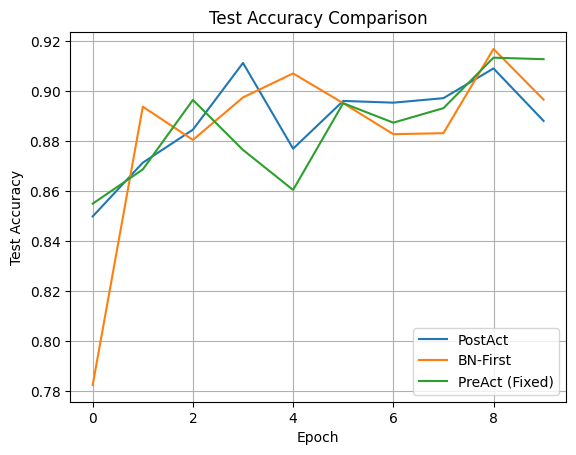

In [2]:
# 🚀 Step 1: 导入库
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ✅ Step 2: 三种残差模块定义（PostAct / BNFirst / PreAct）

# 原版 ResNet 残差块：Conv → BN → ReLU
class Residual_postAct(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides) if use_1x1conv else None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

# BN-First：BN → ReLU → Conv
class Residual_bnFirst(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides) if use_1x1conv else None

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

# 修复后的 PreAct：最后加 ReLU
class Residual_preAct(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides) if use_1x1conv else None

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)  # ✅ 修复：加上ReLU


# ✅ Step 3: 通用残差块构造函数
def resnet_block(block_fn, in_channels, out_channels, num_blocks, first_block=False):
    blocks = []
    for i in range(num_blocks):
        if i == 0 and not first_block:
            blocks.append(block_fn(in_channels, out_channels, use_1x1conv=True, strides=2))
        else:
            blocks.append(block_fn(out_channels, out_channels))
    return nn.Sequential(*blocks)

# ✅ Step 4: 构造完整的 ResNet 模型（传入不同残差块）
def build_resnet(block_fn):
    b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                       nn.BatchNorm2d(64), nn.ReLU(),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b2 = resnet_block(block_fn, 64, 64, 2, first_block=True)
    b3 = resnet_block(block_fn, 64, 128, 2)
    b4 = resnet_block(block_fn, 128, 256, 2)
    b5 = resnet_block(block_fn, 256, 512, 2)
    return nn.Sequential(b1, b2, b3, b4, b5,
                         nn.AdaptiveAvgPool2d((1, 1)),
                         nn.Flatten(),
                         nn.Linear(512, 10))

# ✅ Step 5: 准备数据
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
device = d2l.try_gpu()

# ✅ Step 6: 改写训练函数，记录 test acc
def train_with_history(net, name):
    print(f"\n=== Training: {name} ===")
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    test_acc_list = []

    for epoch in range(num_epochs):
        net.train()
        total_loss, correct, total = 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += y.shape[0]

        # 测试精度
        net.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                test_correct += (net(X).argmax(dim=1) == y).sum().item()
                test_total += y.shape[0]
        test_acc = test_correct / test_total
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}: Train acc = {correct/total:.3f}, Test acc = {test_acc:.3f}")

    return test_acc_list

# ✅ Step 7: 构建并训练模型
net_post = build_resnet(Residual_postAct)
net_bnfirst = build_resnet(Residual_bnFirst)
net_preact = build_resnet(Residual_preAct)

history_post = train_with_history(net_post, 'PostAct')
history_bnfirst = train_with_history(net_bnfirst, 'BN-First')
history_preact = train_with_history(net_preact, 'PreAct (Fixed)')

# ✅ Step 8: 画图对比
def plot_accuracy_curve(histories, labels):
    for hist, label in zip(histories, labels):
        plt.plot(hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.title("Test Accuracy Comparison")
    plt.grid(True)
    plt.show()

plot_accuracy_curve(
    [history_post, history_bnfirst, history_preact],
    ['PostAct', 'BN-First', 'PreAct (Fixed)']
)
